# 12회차: RNN을 활용한 영화평 감성 분석 (2) - 데이터 처리 및 분석

### IMDB 영화평 감성 분석을 위한 라이브러리 로드




In [ ]:
# 1. 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# 2. 환경 설정: GPU 사용 가능 시 GPU 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

Running on: cuda


## IMDB 데이터 처리

In [ ]:
from keras.datasets import imdb
from collections import Counter

# 데이터 로딩
(x_train, y_train), (x_test, y_test) = imdb.load_data()
# 전체 리뷰 수
print(f"학습 샘플 수: {len(x_train)}, 테스트 샘플 수: {len(x_test)}")

# 클래스 분포 확인
train_counter = Counter(y_train)
test_counter = Counter(y_test)
print("라벨 분포 (0 = 부정, 1 = 긍정):")
print(f" - 학습: {dict(train_counter)}")
print(f" - 테스트: {dict(test_counter)}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
학습 샘플 수: 25000, 테스트 샘플 수: 25000
라벨 분포 (0 = 부정, 1 = 긍정):
 - 학습: {np.int64(1): 12500, np.int64(0): 12500}
 - 테스트: {np.int64(0): 12500, np.int64(1): 12500}


In [ ]:
# Keras에서 IMDB 영화 리뷰 데이터셋 모듈을 가져옴
from keras.datasets import imdb

# 단어 → 정수 인덱스 사전 로드
# 단어(문자열)를 키로 하고, 해당 단어의 빈도 순 인덱스(정수)를 값으로 가지는 딕셔너리 반환
word_index = imdb.get_word_index()

# 상위 10개 단어와 해당 인덱스를 출력
# word_index 딕셔너리에서 (key: 단어, value: 순번) 형태로 순회
for i, k in enumerate(word_index):
    if i < 10:                      # 처음 10개 항목만 출력
        print(k, word_index[k])     # 키인 단어와 그에 해당하는 값인 인덱스 출력

fawn 34701
tsukino 52006
nunnery 52007
sonja 16816
vani 63951
woods 1408
spiders 16115
hanging 2345
woody 2289
trawling 52008


In [ ]:
# 'great'이라는 단어의 인덱스 확인
# 예: 'great' → 84은 전체 단어 중 84번째로 자주 등장한 단어
print(word_index['great'])
# 예: 'woods' → 1408은 전체 단어 중 1408번째로 자주 등장한 단어
print(word_index['woods'])

84
1408


In [ ]:
from keras.datasets import imdb

# 단어 인덱스 사전 로드 (단어 → 인덱스)
word_index = imdb.get_word_index()

# 인덱스 기준으로 정렬: [(단어, 인덱스), ...]
# 2번째, 인덱스가 1인 빈도수를 기준으로 정렬
sorted_words = sorted(word_index.items(), key=lambda x: x[1])

# 상위 10개만 출력
# [(단어1, 1), (단어2, 2) ...]
print("인덱스가 낮은(빈도수가 많은) 단어 10개:")
for word, idx in sorted_words[:10]:
    print(f"{word} : {idx}")

인덱스가 낮은(빈도수가 많은) 단어 10개:
the : 1
and : 2
a : 3
of : 4
to : 5
is : 6
br : 7
in : 8
it : 9
i : 10


In [ ]:
import numpy as np
# Keras에서 IMDB 리뷰 데이터셋 모듈 가져오기
from keras.datasets import imdb

# IMDB 데이터셋의 단어 인덱스 사전 로딩 (단어 → 정수 인덱스)
word_index = imdb.get_word_index()
# 전체 고유 단어 수 출력 (예: 약 88,000 단어)
print(f'출현 단어 종류: {len(word_index)}')

# IMDB 데이터셋 로딩 (단어가 이미 인덱스 리스트로 변환된 상태임)
(x_train, y_train), (x_test, y_test) = imdb.load_data()
# 각 훈련 데이터(리뷰)의 단어 수를 리스트로 저장
lengths = [len(x) for x in x_train]

# 리뷰 하나당 단어 수의 최소값과 최대값 출력
print(f'리뷰당 단어수 최소: {np.min(lengths)}, 최대: {np.max(lengths)}')
# 리뷰 단어 수의 평균(mean)과 중앙값(median) 출력
print(f'리뷰당 단어수 평균: {np.mean(lengths):.2f}, 중간: {np.median(lengths)}')
# 사분위수(0%, 25%, 50%, 75%, 90%, 95%) 출력 → 데이터 분포 요약
print(f'리뷰당 단어 사분위 수: {np.percentile(lengths, [0, 25, 50, 75, 90, 95])}')

출현 단어 종류: 88584
리뷰당 단어수 최소: 11, 최대: 2494
리뷰당 단어수 평균: 238.71, 중간: 178.0
리뷰당 단어 사분위 수: [ 11. 130. 178. 291. 467. 610.]


In [ ]:
# 추가 학습
# 리뷰의 단어수가 최소인 학습데이터 첨자
print(int(np.argmin(lengths)))
# 리뷰의 단어수가 최소인 학습데이터 11개 단어 출력
x_train[int(np.argmin(lengths))]

6719


[1, 13, 586, 851, 14, 31, 60, 23, 2863, 2364, 314]

In [ ]:
from keras.datasets import imdb

# 1. 단어 인덱스 사전 불러오기
word_index = imdb.get_word_index()
# Keras 내부 offset 반영
reverse_word_index = {v + 3: k for k, v in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"
reverse_word_index[3] = "<UNUSED>"

# 2. 데이터셋 로드 (전체 단어 포함)
(x_train, y_train), (x_test, y_test) = imdb.load_data()

# 3. 첫 번째 리뷰 선택
sample = x_train[0]
print(f'첫 리뷰의 단어 수: {len(sample)}')
print(f'첫 리뷰 앞 10개:\n {sample[:10]}')
print(f'첫 리뷰 뒤 10개:\n {sample[-10:]}')

# 4. 워드 인덱스와 해당 단어 함께 출력
print("첫 번째 리뷰: 워드 인덱스와 단어 매핑\n")
for idx in sample[:10]:
    # 모르는 인덱스는 ?로 표시
    word = reverse_word_index.get(idx, "?")
    print(f"{idx:<6} → {word}")

첫 리뷰의 단어 수: 218
첫 리뷰 앞 10개:
 [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
첫 리뷰 뒤 10개:
 [4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
첫 번째 리뷰: 워드 인덱스와 단어 매핑

1      → <START>
14     → this
22     → film
16     → was
43     → just
530    → brilliant
973    → casting
1622   → location
1385   → scenery
65     → story


In [ ]:
# 추가 학습
def print_statements(review, n_words):
  from keras.datasets import imdb

  # 1. 단어 인덱스 사전 불러오기
  word_index = imdb.get_word_index()
  # Keras 내부 offset 반영
  reverse_word_index = {v + 3: k for k, v in word_index.items()}
  reverse_word_index[0] = "<PAD>"
  reverse_word_index[1] = "<START>"
  reverse_word_index[2] = "<UNK>"
  reverse_word_index[3] = "<UNUSED>"

  # 4. 워드 인덱스와 해당 단어 함께 출력
  for idx in review[:n_words]:
      # 모르는 인덱스는 ?로 표시
      word = reverse_word_index.get(idx, "?")
      print(f"{idx:<6} → {word}")

print_statements(x_train[int(np.argmin(lengths))], 11)
print_statements(x_train[6719], 11)

1      → <START>
13     → i
586    → wouldn't
851    → rent
14     → this
31     → one
60     → even
23     → on
2863   → dollar
2364   → rental
314    → night
1      → <START>
13     → i
586    → wouldn't
851    → rent
14     → this
31     → one
60     → even
23     → on
2863   → dollar
2364   → rental
314    → night


In [ ]:
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

# 3. 데이터 로딩 및 전처리
vocab_size = 10000  # 빈도 상위 10,000개의 단어만 사용
max_len = 500       # 모든 리뷰를 길이 500으로 패딩 또는 자름

# IMDB 데이터셋 로딩 (이미 토큰화 되어 있음)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

print(x_train.shape, x_test.shape)
print(f'첫 리뷰의 단어 수: {len(x_train[0])}')

(25000,) (25000,)
첫 리뷰의 단어 수: 218


In [ ]:
# 리뷰 길이 맞추기 (길이 부족한 건 0으로 채움)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('패딩 후 2차원 모양: ', x_train.shape, x_test.shape)
print(f'첫 리뷰의 패딩된 첫 10개 단어: {x_train[0][:10]}')
print(f'첫 리뷰의 패딩된 뒤 10개 단어: {x_train[0][-10:]}')

패딩 후 2차원 모양:  (25000, 500) (25000, 500)
첫 리뷰의 패딩된 첫 10개 단어: [0 0 0 0 0 0 0 0 0 0]
첫 리뷰의 패딩된 뒤 10개 단어: [4472  113  103   32   15   16 5345   19  178   32]


## 텍스트 데이터 분석: 단어 임베딩

In [ ]:
import numpy as np

# 버전 체크 (환경 정합 확인)
print("NumPy :", np.__version__)

NumPy : 2.0.2


In [ ]:
# 처음 실행시 라이브러리 없음
# WARNING: Package(s) not found: gensim
!pip show gensim

In [ ]:
# 처음 실행 시 설치하고 restart session 해야
# 설치된 gensim에 맞는 numpy가 설치된 상태로 수행 가능
!pip install gensim==4.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatibl

In [ ]:
# 설치 후 다시 처음 실행시 라이브러리 정보 있음
# Version: 4.3.3
!pip show gensim

Name: gensim
Version: 4.3.3
Summary: Python framework for fast Vector Space Modelling
Home-page: https://radimrehurek.com/gensim/
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, scipy, smart-open
Required-by: 


In [ ]:
# import gensim
import numpy as np
import scipy, gensim

# 버전 체크 (환경 정합 확인)
print("NumPy :", np.__version__)
print("SciPy :", scipy.__version__)
print("gensim:", gensim.__version__)

NumPy : 1.26.4
SciPy : 1.13.1
gensim: 4.3.3


In [ ]:
# 세션을 다시 시작하자
# !pip install -U gensim # 최신 버전 설치 명령

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatib

In [ ]:
import numpy as np
from gensim.models import Word2Vec

# 샘플 문장들 (토큰화된 형태로 입력되어야 함)
sentences = [
    ["i", "love", "machine", "learning"],
    ["deep", "learning", "is", "a", "subset", "of", "machine", "learning"],
    ["word", "embedding", "maps", "words", "to", "vectors"],
    ["i", "love", "deep", "learning"],
    ["natural", "language", "processing", "is", "fun"]
]

# Word2Vec 모델 학습
model = Word2Vec(sentences, vector_size=10, window=3,
                 min_count=1, sg=1, epochs=100)

# word에 저장된 단어의 임베딩 벡터 출력 (10차원)
word = 'machine'
print(f"Vector for '{word}':")
print(model.wv[word].shape)
np.set_printoptions(precision=2)
print(f"model.wv[word]: {model.wv[word]}")

# word에 저장된 단어와 가장 유사한 단어 3개 출력
print(f"Top 3 similar words to '{word}':")
print(model.wv.most_similar(word, topn=3))

Vector for 'machine':
(10,)
model.wv[word]: [-0.08 -0.01  0.1  -0.07 -0.02 -0.02  0.08 -0.06 -0.   -0.05]
Top 3 similar words to 'machine':
[('word', 0.7661800384521484), ('a', 0.30279743671417236), ('natural', 0.30066001415252686)]


In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 99.1 MB/s eta 0:00:00


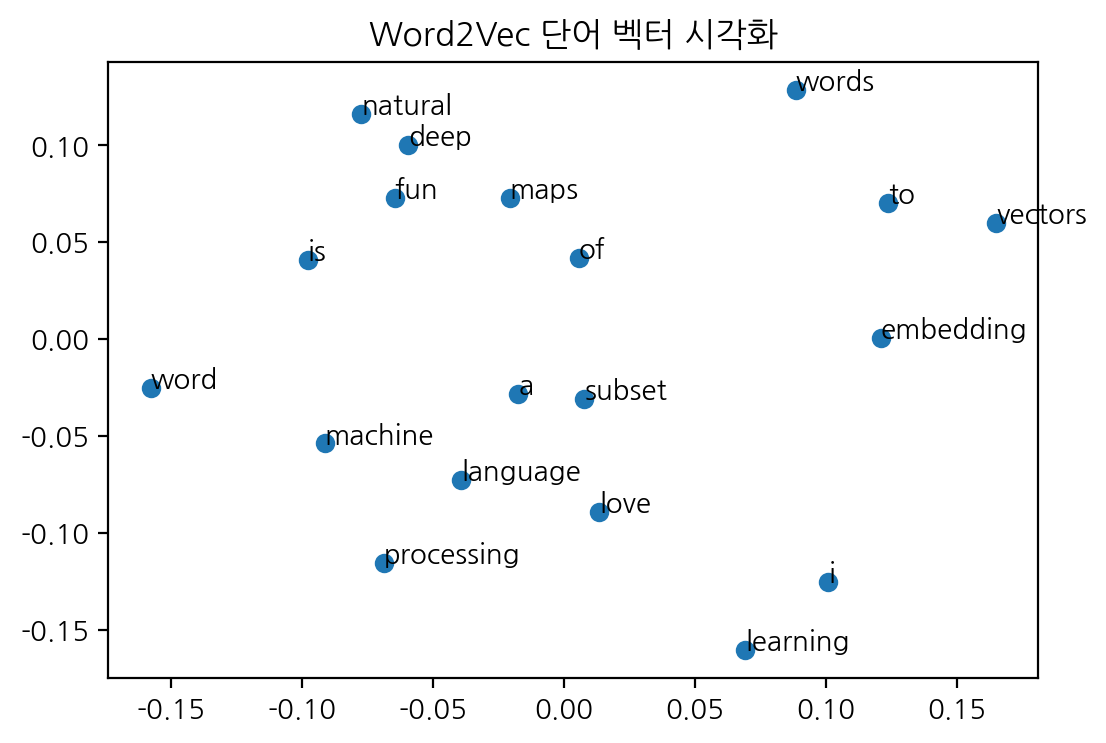

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words = list(model.wv.index_to_key)
X = model.wv[words]
X_reduced = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(6, 4))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(X_reduced[i, 0], X_reduced[i, 1]))

plt.title("Word2Vec 단어 벡터 시각화")
plt.show()

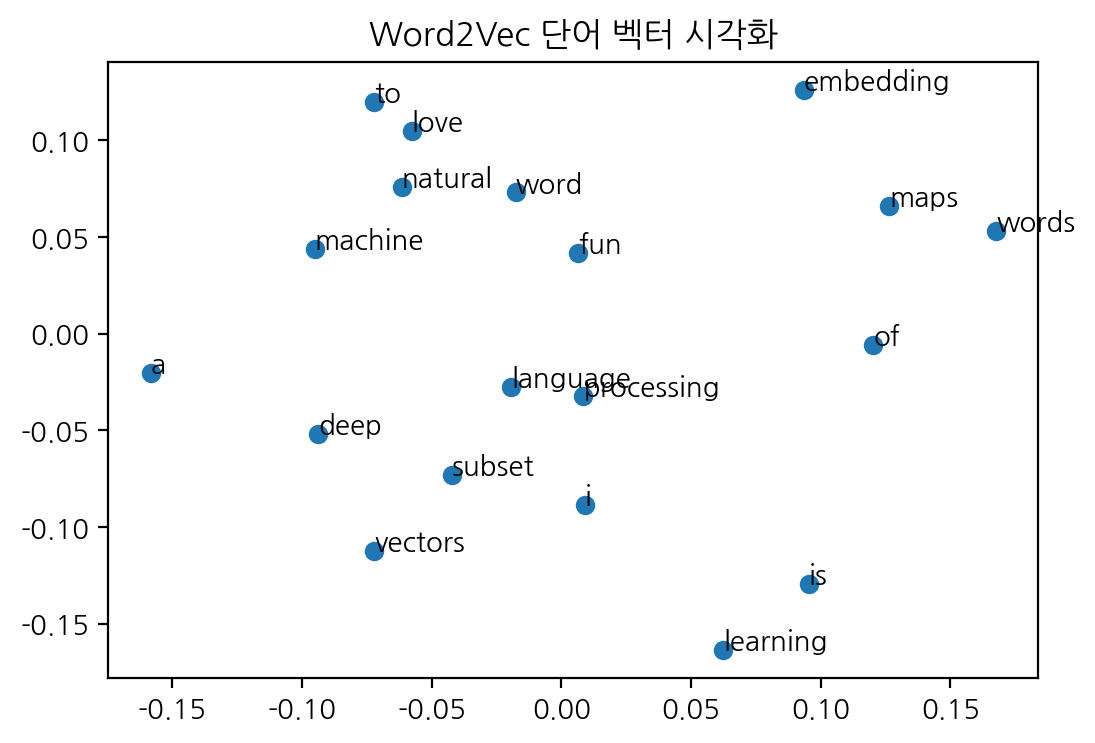

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words = list(model.wv.index_to_key)
X = model.wv[words]
X_reduced = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(6, 4))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(X_reduced[i, 0], X_reduced[i, 1]))

plt.title("Word2Vec 단어 벡터 시각화")
plt.show()

### 심화 학습

In [ ]:
# 1. Word2Vec 사전학습 벡터 로드 (Google News, 300차원)
import time
import gensim.downloader as api

# 1. 사전 학습된 Google News Word2Vec 불러오기
# (자동 다운로드: 약 1.5GB, 처음엔 시간 걸림)
start = time.time()
print("모델 다운로드 중 (잠시 시간 걸림)...")
model = api.load("word2vec-google-news-300")  # 1.5GB 정도
print("모델 로딩 완료!")
end = time.time()
print(f"실행 시간: {end - start:.2f}초")

모델 다운로드 중 (잠시 시간 걸림)...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
모델 로딩 완료!
실행 시간: 223.51초


In [ ]:
# 3. 특정 단어의 벡터 확인
print("벡터 크기:", model["computer"].shape)
print("computer 단어 벡터:", model["computer"][:10])  # 앞 10개만 출력

# 4. 단어 유사도 계산
print("computer vs laptop 유사도:", model.similarity("computer", "laptop"))

벡터 크기: (300,)
computer 단어 벡터: [ 0.11 -0.2   0.12  0.21 -0.09  0.22 -0.13  0.08  0.2   0.05]
computer vs laptop 유사도: 0.66404927


In [ ]:
# 5. 단어 벡터 연산
result = model.most_similar(positive=['king', 'woman'], negative=['man'], topn=5)

print("\n'king' - 'man' + 'woman' ≈ ???")
for word, score in result:
    print(f"{word:<10}  (similarity: {score:.4f})")


'king' - 'man' + 'woman' ≈ ???
queen       (similarity: 0.7118)
monarch     (similarity: 0.6190)
princess    (similarity: 0.5902)
crown_prince  (similarity: 0.5499)
prince      (similarity: 0.5377)


In [ ]:
# Paris - France + Italy ≈ ?
result = model.most_similar(positive=["Paris", "Italy"], negative=["France"], topn=3)
print(result)

[('Milan', 0.7222141623497009), ('Rome', 0.702830970287323), ('Palermo_Sicily', 0.5967570543289185)]


In [ ]:
# man - woman + queen ≈ ?
result = model.most_similar(positive=["man", "queen"], negative=["woman"], topn=3)
print(result)

[('king', 0.6958590149879456), ('kings', 0.5950952768325806), ('queens', 0.583850085735321)]


In [ ]:
# !pip install gensim

from gensim.models import KeyedVectors

# ⬇️ 본인 환경의 파일 경로로 교체
MODEL_PATH = "/path/to/kowiki.word2vec.bin"   # 예) 'kowiki_300d.bin' 또는 'kowiki_300d.vec'
IS_BINARY  = True                              # .bin이면 True, .vec이면 False

kv = KeyedVectors.load_word2vec_format(MODEL_PATH, binary=IS_BINARY)
print("단어 수:", len(kv), "차원:", kv.vector_size)


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/kowiki.word2vec.bin'

## 종료